## Optimizing Community Engagement- Advanced Analytics of Facebook Group Posts

A copy of this notebook has also been uploaded to https://github.com/rozank/dsc680_applied_datascience/tree/main/Project-3

In [9]:
#import libraries

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import RegexpTokenizer
import re
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from wordcloud import WordCloud
from plotly.subplots import make_subplots




# suppress all warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [11]:
users_df=pd.read_excel("ch_users.xlsx")
posts_df=pd.read_excel("ch_posts.xlsx")

### Data Cleaning

In [12]:
## Clean Facebook Post Data (posts_df)

# Remove non-alphabet characters from column names and convert to lowercase for readability
posts_df.columns = ["".join(filter(str.isalpha, col)).lower() for col in posts_df.columns]

In [13]:
# Keep only selected columns
posts_df = posts_df[['createdat','commentcount', 'reactioncount', 'text', 'userid']]

# Convert 'createdAt' column to datetime format from Unix timestamp format.
posts_df['createdat'] = pd.to_datetime(posts_df['createdat'], unit='s')

# Generate a random ID for each unique userid to hide the identity, since userid is the unique identity provided by Facebook
unique_ids = posts_df['userid'].unique()
random_ids = np.random.randint(1, 1e6, size=len(unique_ids))
id_mapping = dict(zip(unique_ids, random_ids))

# Map the random IDs to a new column 'new_id'
posts_df['newid'] = posts_df['userid'].map(id_mapping)

In [14]:
# Clean userdata(user_df)

# Remove non-alphabet characters from column names and convert to lowercase for readability
users_df.columns = ["".join(filter(str.isalpha, col)).lower() for col in users_df.columns]

# Convert 'createdAt' column to datetime format from Unix timestamp format.
users_df['joinedat'] = pd.to_datetime(users_df['joinedat'], unit='s')

# Keep only selected columns
users_df=users_df[['joinedat','userid']]

In [15]:
# Merge two dataset so the final dataset can have the user's joined date
df = pd.merge(posts_df, users_df, on='userid', how='left')

# Drop records where text column is NAN which can happen if user posts picture
df = df.dropna(subset=['text'])

### EDA

#### Month Over Month User Growth

In [16]:
# Convert 'joinedat' to datetime if it's not already
df['joinedat'] = pd.to_datetime(df['joinedat'])

# Extract year and month from 'joinedat' for aggregation
df['year_month'] = df['joinedat'].dt.to_period('M')

# Count unique users per month
monthly_users = df.groupby('year_month')['userid'].nunique().reset_index(name='unique_users')

# Calculate month-over-month growth in unique users
monthly_users['month_over_month_growth'] = (monthly_users['unique_users'].pct_change() * 100).round(1)

# Convert 'year_month' back to string for plotting
monthly_users['year_month'] = monthly_users['year_month'].astype(str)
print(monthly_users)

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add the bar chart for unique users with custom hover text
fig.add_trace(
    go.Bar(
        x=monthly_users['year_month'], 
        y=monthly_users['unique_users'], 
        name='Unique Users', 
        marker_color='skyblue',
        hovertemplate='Month: %{x}<br>Unique Users: %{y}<extra></extra>',  # Custom hover text
    ),
    secondary_y=False,
)

# Add the line chart for MoM growth with custom hover text
fig.add_trace(
    go.Scatter(
        x=monthly_users['year_month'], 
        y=monthly_users['month_over_month_growth'], 
        name='M-O-M Growth (%)', 
        mode='lines+markers', 
        line=dict(color='green'),
        hovertemplate='Month: %{x}<br>M-O-M Growth: %{y:.1f}%<extra></extra>',  # Custom hover text with rounding
    ),
    secondary_y=True,
)

# Update layout and axes
fig.update_layout(
    title_text='Monthly User Growth and Month-over-Month Growth Percentage',
    width=1000,  # Adjusted for clarity
    height=700,
)
fig.update_xaxes(
    title_text='Year-Month',
    tickangle=-90,
    tickvals=monthly_users['year_month'],
    ticktext=monthly_users['year_month'],
)
fig.update_yaxes(title_text='Unique Users', secondary_y=False)
fig.update_yaxes(title_text='Month-Over-Month Growth (%)', secondary_y=True)

# Show the figure
fig.show()


   year_month  unique_users  month_over_month_growth
0     2021-04             1                      NaN
1     2021-08            15                   1400.0
2     2021-09             9                    -40.0
3     2021-10             3                    -66.7
4     2021-11            12                    300.0
5     2021-12            29                    141.7
6     2022-01             9                    -69.0
7     2022-02             8                    -11.1
8     2022-03            24                    200.0
9     2022-04            16                    -33.3
10    2022-05            15                     -6.2
11    2022-06            13                    -13.3
12    2022-07             4                    -69.2
13    2022-08             2                    -50.0
14    2022-09             5                    150.0
15    2022-10            14                    180.0
16    2022-11             9                    -35.7
17    2022-12            11                   

NameError: name 'go' is not defined

#### Distribution of post among members

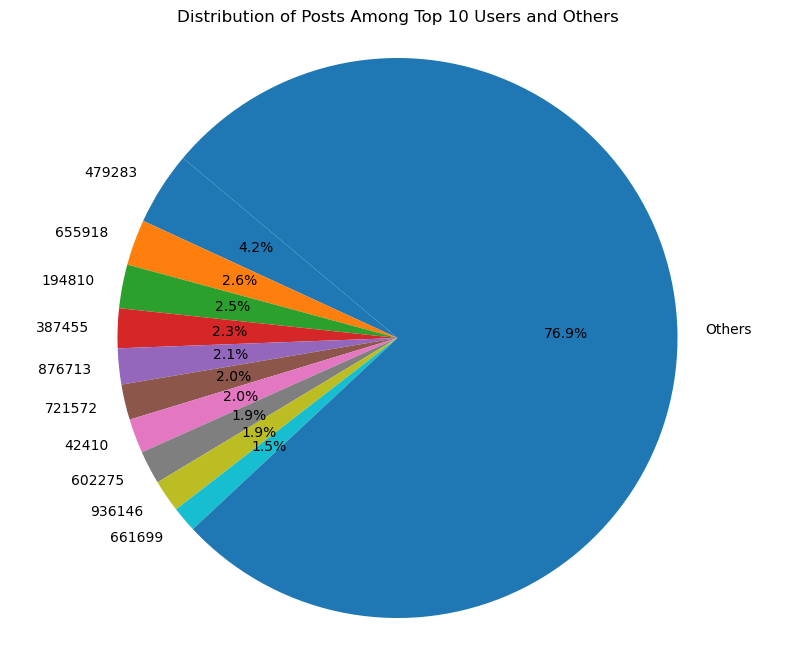

In [17]:
# Calculate the distribution of posts among all users
user_post_distribution = df['newid'].value_counts()

# Convert to percentage
user_post_distribution_percentage = (user_post_distribution / user_post_distribution.sum()) * 100

# Create a DataFrame for easier handling
distribution_df = pd.DataFrame({'User': user_post_distribution.index, 'Percentage': user_post_distribution_percentage})

# For a more detailed view, let's consider plotting the distribution of the top N users
N = 10  # Adjust N to include more or fewer users in the visualization

# Calculate the percentage for "Others"
others_percentage = distribution_df['Percentage'][N:].sum()

# For plotting, directly create labels and sizes
labels = distribution_df['User'].head(N).tolist() + ['Others']
sizes = distribution_df['Percentage'].head(N).tolist() + [others_percentage]

# Plotting the pie chart for the top N users and Others
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f'Distribution of Posts Among Top {N} Users and Others')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

~23% of the group posts are coming from top 10 users

### Trend Analysis

The trend analysis shows the monthly post volume over time. This visualization can help us identify any noticeable trends or patterns in how frequently users are posting in the group. For instance, peaks might indicate periods of high activity, possibly due to special events, seasonal topics, or other community-driven factors.

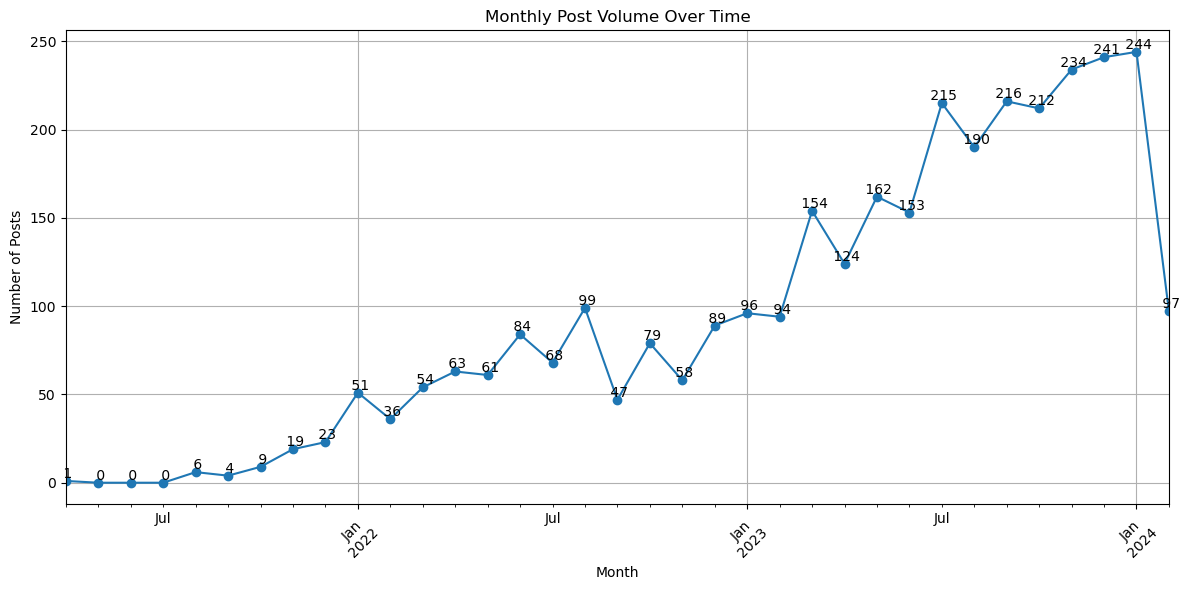

Result of Trend Analysis:



createdat
2021-04-30      1
2021-05-31      0
2021-06-30      0
2021-07-31      0
2021-08-31      6
2021-09-30      4
2021-10-31      9
2021-11-30     19
2021-12-31     23
2022-01-31     51
2022-02-28     36
2022-03-31     54
2022-04-30     63
2022-05-31     61
2022-06-30     84
2022-07-31     68
2022-08-31     99
2022-09-30     47
2022-10-31     79
2022-11-30     58
2022-12-31     89
2023-01-31     96
2023-02-28     94
2023-03-31    154
2023-04-30    124
2023-05-31    162
2023-06-30    153
2023-07-31    215
2023-08-31    190
2023-09-30    216
2023-10-31    212
2023-11-30    234
2023-12-31    241
2024-01-31    244
2024-02-29     97
dtype: int64

In [18]:
# Lets copy the dataframe so we are not impacting the master dataset
trend_df= df.copy()

# Convert 'createdat' to datetime format and set it as the index
trend_df['createdat'] = pd.to_datetime(trend_df['createdat'])
trend_df.set_index('createdat', inplace=True)

# Resample the data to get a monthly count of posts
monthly_posts = trend_df.resample('M').size()


plt.figure(figsize=(12, 6))
# Plotting the line chart
monthly_posts.plot(kind='line', marker='o', color='tab:blue')

# Adding data annotations to each point
for date, value in monthly_posts.items():  # Use items() for Series
    plt.text(date, value, f' {value}', ha='center', va='bottom')

plt.title('Monthly Post Volume Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Posts')

# Improve readability of x-axis labels
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()



print("Result of Trend Analysis:\n")
monthly_posts

### Topic Analysis

In [19]:
# Lets copy the dataframe so we are not impacting the master dataset
topic_df = df.copy()


# Download NLTK stopwords and ensure they are available
nltk.download('stopwords')
from nltk.corpus import stopwords


# Extend the NLTK stopwords list with additional common but uninformative words
extended_stopwords = set(stopwords.words('english')).union({
    'a', 'i', 's', 't', 'the', 'my', 'me', 'just', 'so', 'know', 'please', 'does', 'let', 'new', 'anyone','hello','hi','15','hey',
    'us','go','get','would','com','pkwy','yet','dr','st',})

# Preprocess the text data: remove stopwords and non-alphanumeric characters
def preprocess(text):
    tokenizer = RegexpTokenizer(r'\w+')  # Tokenizer to extract words
    tokens = tokenizer.tokenize(text.lower())  # Tokenize and convert to lower case
    # Filter out tokens not in the extended stopwords list and are alphabetic
    filtered_tokens = [token for token in tokens if token not in extended_stopwords and re.match('^[a-zA-Z]+$', token)]
    return filtered_tokens

# Apply preprocessing to the text column
topic_df['processed_text'] = topic_df['text'].apply(preprocess)

# Create a dictionary and corpus for Topic Modeling
dictionary = corpora.Dictionary(topic_df['processed_text'])  # Map each word to a unique id
corpus = [dictionary.doc2bow(text) for text in topic_df['processed_text']]  # Convert documents to vectors

# Apply TF-IDF to transform the corpus
tfidf_model = models.TfidfModel(corpus)  # Initialize and train the TF-IDF model
corpus_tfidf = tfidf_model[corpus]  # Apply TF-IDF transformation to the entire corpus

# Define the number of topics for the LDA model
num_topics = 10

# Run LDA using the TF-IDF transformed corpus
lda_model = models.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Display the topics identified by the LDA model
print("Result of Topic Analysis:\n")
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10)
for topic in topics:
    print(topic)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mrgrey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Result of Topic Analysis:

(0, '0.005*"cleaning" + 0.005*"cibolo" + 0.005*"business" + 0.004*"good" + 0.004*"hills" + 0.004*"days" + 0.004*"notary" + 0.004*"reminder" + 0.004*"admins" + 0.004*"tomorrow"')
(1, '0.008*"power" + 0.005*"bonds" + 0.004*"ranch" + 0.004*"bus" + 0.004*"allowed" + 0.004*"else" + 0.003*"lagoon" + 0.003*"school" + 0.003*"everyone" + 0.002*"formula"')
(2, '0.003*"trash" + 0.003*"repair" + 0.003*"case" + 0.003*"rules" + 0.003*"monthly" + 0.003*"wondering" + 0.003*"playground" + 0.003*"welcome" + 0.003*"members" + 0.003*"picked"')
(3, '0.005*"star" + 0.005*"gold" + 0.004*"transit" + 0.004*"eagle" + 0.004*"entrance" + 0.004*"mountain" + 0.004*"hoa" + 0.004*"solar" + 0.004*"august" + 0.004*"elementary"')
(4, '0.004*"muckleshoot" + 0.003*"inspection" + 0.003*"treating" + 0.003*"warranty" + 0.003*"saw" + 0.002*"closed" + 0.002*"guys" + 0.002*"sprinkler" + 0.002*"trick" + 0.002*"year"')
(5, '0.009*"bulk" + 0.006*"trash" + 0.005*"week" + 0.004*"pickup" + 0.003*"pick" + 0.

Local Services and Community Engagement: The mention of "cleaning", "cibolo", "business", and "notary" suggests a focus on local services and businesses, possibly indicating discussions around recommendations, experiences, or scheduling. The term "reminder" alongside "admins" and "tomorrow" could point to community events or important notices shared by group administrators.

Infrastructure and Education: References to "power", "bonds", "ranch", and "bus" highlight conversations around local infrastructure and school-related logistics. "Lagoon" and "school" alongside "allowed" and "everyone" might indicate discussions about community amenities and school policies or events.

Community Rules and Maintenance: With terms like "trash", "repair", "rules", and "monthly", this topic likely covers waste management, home maintenance, and community guidelines. "Welcome" and "members" suggest a focus on community integration and rules for new residents.

Environmental Initiatives and Community Management: "Star", "gold", "transit", and "solar" indicate discussions on environmental initiatives and local transportation options. "Eagle", "entrance", and "mountain" alongside "hoa" could reflect conversations about community aesthetics, management, and possibly local wildlife or environmental conservation efforts.

Home Maintenance and Local Issues: Terms such as "muckleshoot", "inspection", and "warranty" suggest a focus on home maintenance and warranty services, while "treating" and "sprinkler" hint at lawn care and maintenance discussions.

Waste Management: "Bulk" and "trash" with "pickup" and "week" are clearly focused on waste management schedules and guidelines, possibly including special bulk trash collection events.

Package Delivery and Security: The prominence of "package", "delivered", "missing", and "mailbox" indicates a significant concern with package delivery issues, including missing or wrongly delivered packages, a common community concern given the rise of online shopping.

Amenities and Services Recommendations: Discussions around "pool", "recommendations", "hoa", and "spectrum" relate to community amenities and service provider recommendations, including internet services, indicating an active exchange of advice and experiences.

Emergency Services and Community Support: The mention of "ems", "isd", along with "recommendations" and "safe" suggests discussions on emergency services, school district information, and community safety initiatives.

Community Support and Exchange: Terms like "free", "want", "need", and "moving" indicate a culture of sharing and support, with community members expressing needs, offering items for free, or seeking advice related to moving.

In [20]:
# Prepare the visualization
vis = gensimvis.prepare(lda_model, corpus_tfidf, dictionary)

# Display the visualization in Jupyter Notebook
pyLDAvis.display(vis)

#### Wordcloud to see what are the most used words

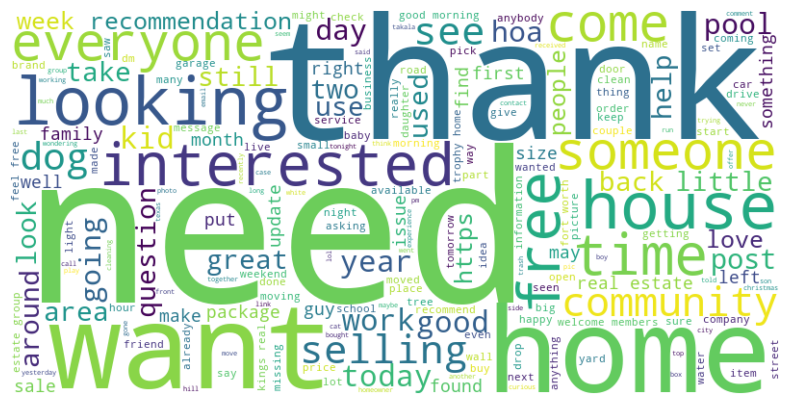

In [21]:
# adding few more words to remove as they were dominating the wordcloud and we want to omit them
words_to_remove = {'neighbor', 'neighbors','neighborhood','got','one','cibolo'}

# Filter out the specified words from each document's list of tokens and aggregate into a single string
# topic_df['processed_text'] is being borrowed fromn top 

word_cloud_text = " ".join([" ".join([word for word in text if word not in words_to_remove])
                                        for text in topic_df['processed_text']])

# create the word cloud with the aggregated processed text
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(word_cloud_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Topic Analysis within top 10 posters

In [22]:
top_posters = df['newid'].value_counts().head(10).index.tolist()
top_posts = df[df['newid'].isin(top_posters)]

# Initialize an empty list to store the result (to be able to print result in table format)
results = []

# Create a list of extended stopwords from previous cell
extended_stopwords_list = list(extended_stopwords)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10, stop_words=extended_stopwords_list)

# Analyze posts for each top poster
for user in top_posters:
    user_posts = top_posts[top_posts['newid'] == user]['text'].tolist()
    tfidf_matrix = tfidf.fit_transform(user_posts)
    feature_names = tfidf.get_feature_names_out()
    
    # Store the result for each user
    results.append({
        'User ID': user,
        'Top Terms': ', '.join(feature_names)
    })

    
#convert the list of results into a DataFrame
results_df = pd.DataFrame(results)
print("Result of Topic Analysis among Top 10 posters:\n")
results_df

Result of Topic Analysis among Top 10 posters:



,User ID,Top Terms
0,479283,"admins, business, cibolo, community, days, good, hills, members, one, welcome"
1,655918,"community, dog, dogs, hills, like, one, park, trash, work, year"
2,194810,"dog, duck, everyone, hoa, https, looking, one, pool, scoop, today"
3,387455,"community, estate, group, help, home, kings, one, real, realtor, win"
4,876713,"fixed, garage, home, house, need, recommendations, thanks, time, update, want"
5,721572,"custom, details, dm, interested, make, need, pricing, selling, size, two"
6,42410,"big, dog, hills, like, looking, package, parkway, side, tall, time"
7,602275,"black, clean, going, hoa, one, pool, someone, thanks, want, water"
8,936146,"community, group, hoa, like, looks, neighbors, page, pool, posts, see"
9,661699,"2022, august, city, community, ems, gold, isd, school, star, transit"


Table showing what are the topics that the top 10 posters/users posting about